In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Database connection settings
DB_CONFIG = {
    'host': 'localhost',
    'database': 'SQLTEST',
    'user': 'postgres',
    'password': 'Admin'
}

In [4]:
# Connect to the database
conn = psycopg2.connect(**DB_CONFIG)

In [5]:
# Execute the updated SQL query and load into a DataFrame
query = """
WITH UserRevenue AS (
    SELECT 
        gc.user_id,
        SUM(o.total_amount) AS total_revenue,
        COUNT(DISTINCT g.id) AS group_count
    FROM 
        orders o
    JOIN 
        groups_carts gc ON o.groups_carts_id = gc.id
    JOIN 
        groups g ON gc.group_id = g.id
    WHERE 
        o.created_at >= NOW() - INTERVAL '60 days' 
        AND o.status = 'COMPLETED'
    GROUP BY 
        gc.user_id
),
UserCategories AS (
    SELECT 
        u.id AS user_id,
        ARRAY_AGG(DISTINCT c.name) AS categories
    FROM 
        users u
    JOIN 
        groups_carts gc ON u.id = gc.user_id
    JOIN 
        groups g ON gc.group_id = g.id
    JOIN 
        group_deals gd ON g.group_deals_id = gd.id
    JOIN 
        products p ON gd.product_id = p.id
    JOIN 
        product_names pn ON p.name_id = pn.id
    JOIN 
        categories c ON pn.category_id = c.id
    GROUP BY 
        u.id
)
SELECT 
    u.user_id,
    usr.name,
    u.total_revenue,
    u.group_count,
    uc.categories
FROM 
    UserRevenue u
LEFT JOIN 
    UserCategories uc ON u.user_id = uc.user_id
JOIN 
    users usr ON u.user_id = usr.id
ORDER BY 
    u.total_revenue DESC
LIMIT 10;
"""


In [6]:
df = pd.read_sql_query(query, conn)
conn.close()

C:\Users\huawei\AppData\Local\Temp\ipykernel_16596\711990737.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [7]:
# Display the DataFrame
df.head()

,user_id,name,total_revenue,group_count,categories
0,d25a7eb5-3e7d-40d2-bc30-e370111e79f1,Tsion,9894.0,40,"[Baby Items, Condiments , Fruit, Packed Food &..."
1,02afef07-11f8-4a29-848a-ebae8c3dd783,Nahom,9231.6,42,"[Baby Items, Cloth & Fashion, Condiments , Dai..."
2,cdb909c0-8549-4c1a-9345-8a6c22e09dc8,Dero,8961.0,35,"[Baby Items, Condiments , Dairy, Fruit, Packed..."
3,ef7c0d65-1619-4685-8527-3b65a194bfd6,Etalem,8648.0,39,"[Baby Items, Condiments , Fruit, Packed Food &..."
4,a69c75d9-31d2-49fc-98a3-93d937bb011f,fikadu,8385.0,38,"[Baby Items, Condiments , Dairy, Fruit, Packed..."


In [8]:
# Convert categories to count for plotting
df['categories_count'] = df['categories'].apply(lambda x: len(x))

In [9]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

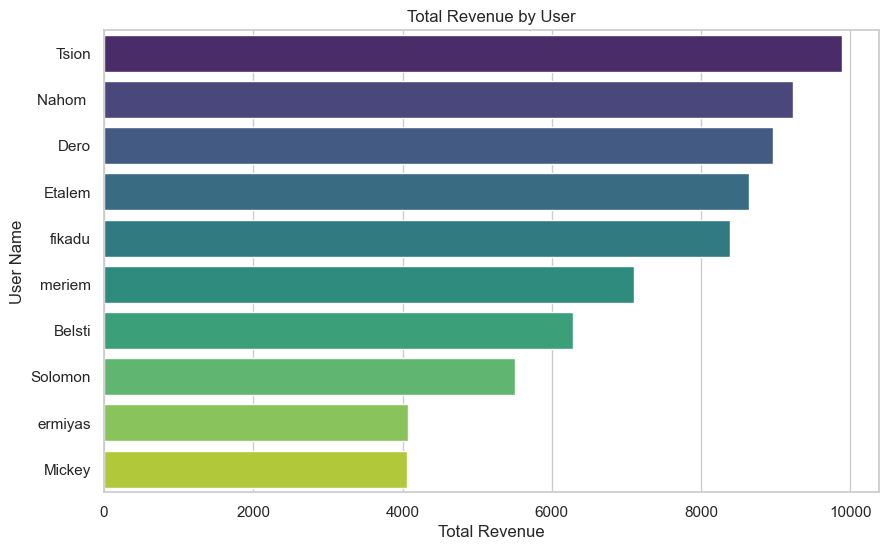

In [10]:
# 1. Bar Chart of Total Revenue by User
plt.figure(figsize=(10, 6))
sns.barplot(x='total_revenue', y='name', data=df, palette='viridis')
plt.title('Total Revenue by User')
plt.xlabel('Total Revenue')
plt.ylabel('User Name')
plt.show()

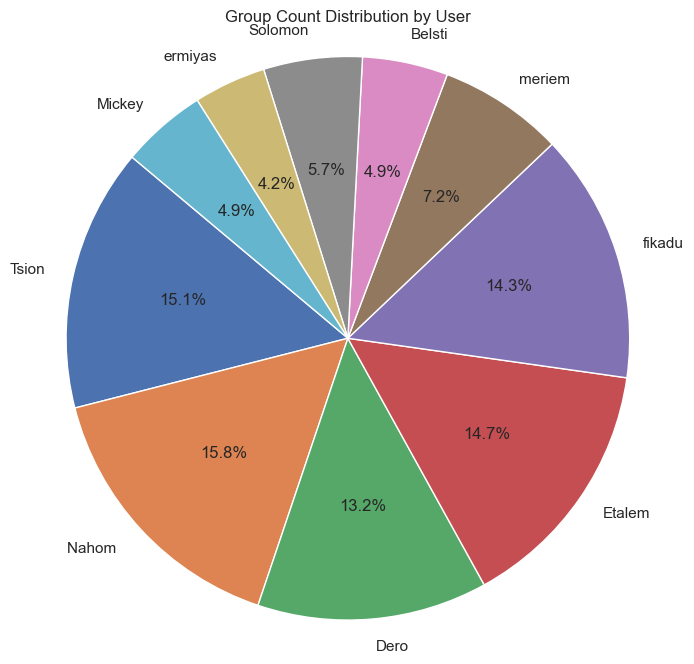

In [ ]:
# 2. Pie Chart of Group Count Distribution
plt.figure(figsize=(8, 8))
plt.pie(df['group_count'], labels=df['name'], autopct='%1.1f%%', startangle=140)
plt.title('Group Count Distribution by User')
plt.axis('equal')  
plt.show()


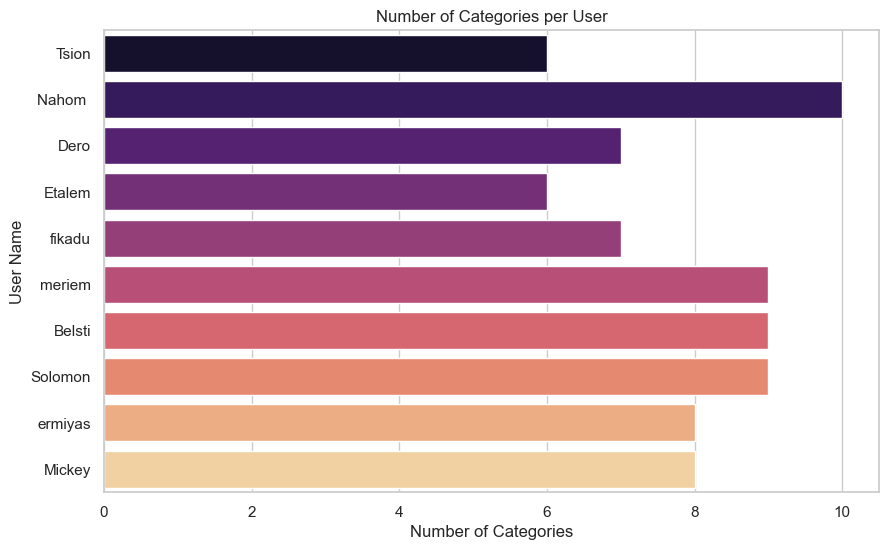

In [12]:
# 3. Bar Chart of Categories Count per User
plt.figure(figsize=(10, 6))
sns.barplot(x='categories_count', y='name', data=df, palette='magma')
plt.title('Number of Categories per User')
plt.xlabel('Number of Categories')
plt.ylabel('User Name')
plt.show()